In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot
from numpy import zeros, asarray
import cv2

import mrcnn.utils
import mrcnn.config
import mrcnn.model
import mrcnn.visualize

from PIL import Image
import scipy.io
import random

Using TensorFlow backend.


In [41]:
class FaceDataset(mrcnn.utils.Dataset):
    def load_dataset(self, is_train=True):
        self.add_class("dataset", 1, "face")
        fic=""
        if not is_train:
            mat = scipy.io.loadmat('../../asset/Train/Keras/test/wider_face_val.mat')
            fic="WIDER_val"
        if is_train:
            mat = scipy.io.loadmat('../../asset/Train/Keras/test/wider_face_train.mat')
            fic="WIDER_train"
        for i in range(len(mat['file_list'])-1):
            for j in range(len(mat['file_list'][i][0])-1):
                numCatReel = mat['file_list'][i][0][j][0][0].split("_")[0]
                for dir in os.listdir("../../asset/Train/Keras/"+fic+"/images"):
                    if dir.split("-")[0] == numCatReel:
                        break
                path="../../asset/Train/Keras/"+fic+"/images/"+dir+"/"+mat['file_list'][i][0][j][0][0]+".jpg"
                imgId=i*j+1
                self.add_image('dataset', image_id=imgId, path=path,i=i,j=j)
    def load_mask(self, image_id):
        mat = scipy.io.loadmat('../../asset/Train/Keras/test/wider_face_train.mat')
        info = self.image_info[image_id]
        i = info['i']
        j = info['j']
        image = info['path']
        img = Image.open(image)
        w, h = img.size
        boxes = mat['face_bbx_list'][i][0][j][0]
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_s+row_e, col_s:col_s+col_e, i] = 1
            class_ids.append(self.class_names.index('face'))
        return masks, asarray(class_ids, dtype='int32')

In [42]:
class FaceConfig(mrcnn.config.Config):
    NAME = "face_cfg"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    NUM_CLASSES = 2

    STEPS_PER_EPOCH = 131


In [43]:
train_set = FaceDataset()
train_set.load_dataset(is_train=True)
train_set.prepare()

valid_dataset = FaceDataset()
valid_dataset.load_dataset(is_train=False)
valid_dataset.prepare()

face_config = FaceConfig()

model = mrcnn.model.MaskRCNN(mode='training', 
                             model_dir='./', 
                             config=face_config)

model.load_weights(filepath='Face_mask_rcnn.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

history = model.train(train_dataset=train_set, 
            val_dataset=valid_dataset, 
            learning_rate=face_config.LEARNING_RATE, 
            epochs=7, 
            layers='heads')

model_path = 'Face_mask_rcnn.h5'
model.keras_model.save_weights(model_path)


Starting at epoch 0. LR=0.001

Checkpoint Path: ./face_cfg20210110T1334\mask_rcnn_face_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDis

In [44]:
history.history


{'val_loss': [4.512224700450897,
  4.0188169300556185,
  2.26874461889267,
  2.2419812941551207],
 'val_rpn_class_loss': [1.04279281437397,
  0.8105034112930298,
  0.7167041963338852,
  0.4129241627454758],
 'val_rpn_bbox_loss': [2.878066554069519,
  2.1611364275217055,
  1.2813853824138641,
  0.9373162131011487],
 'val_mrcnn_class_loss': [0.009346811771392823,
  0.013504190966486931,
  1.1920928688624598e-11,
  0.06408776432275771],
 'val_mrcnn_bbox_loss': [0.51644371509552,
  0.9563062858581542,
  0.2577210426330566,
  0.636284458041191],
 'val_mrcnn_mask_loss': [0.06557140231132508,
  0.0773632299900055,
  0.012930617332458497,
  0.1913653779029846],
 'loss': [5.710488090988334,
  3.7564101883473286,
  2.395423023072818,
  2.074911752957424],
 'rpn_class_loss': [1.1732225220167,
  0.8207722048324938,
  0.462393676933214,
  0.4458632894030964],
 'rpn_bbox_loss': [4.235222478859297,
  2.658126093504083,
  1.32598834501878,
  0.9420863153370282],
 'mrcnn_class_loss': [0.056493366427129

In [61]:
val2 = {'val_loss': [4.512224700450897,4.0188169300556185,2.26874461889267,2.2419812941551207],
 'val_rpn_class_loss': [1.04279281437397,0.8105034112930298,0.7167041963338852,0.4129241627454758],
 'val_rpn_bbox_loss': [2.878066554069519,2.1611364275217055,1.2813853824138641,0.9373162131011487],
 'val_mrcnn_class_loss': [0.009346811771392823,0.013504190966486931,1.1920928688624598e-11,0.06408776432275771],
 'val_mrcnn_bbox_loss': [0.51644371509552,0.9563062858581542,0.2577210426330566,0.636284458041191],
 'val_mrcnn_mask_loss': [0.06557140231132508,0.0773632299900055,0.012930617332458497,0.1913653779029846],
 'loss': [5.710488090988334,3.7564101883473286,2.395423023072818,2.074911752957424],
 'rpn_class_loss': [1.1732225220167,0.8207722048324938,0.462393676933214,0.4458632894030964],
 'rpn_bbox_loss': [4.235222478859297,2.658126093504083,1.32598834501878,0.9420863153370282],
 'mrcnn_class_loss': [0.05649336642712996,0.011053262790309456,0.008803284487632165,0.027272946579244353],
 'mrcnn_bbox_loss': [0.21744261625158878,0.21432677662099592,0.5428182514569232,0.5717647803648738],
 'mrcnn_mask_loss': [0.028103744255677434,0.05212849242086629,0.055416114912688275,0.08792108479346938]}

val = {'val_loss': [7.124860610961914],
 'val_rpn_class_loss': [1.8172586596012115],
 'val_rpn_bbox_loss': [5.260878140926361],
 'val_mrcnn_class_loss': [1.1920928688624598e-11],
 'val_mrcnn_bbox_loss': [0.03317064523696899],
 'val_mrcnn_mask_loss': [0.013549716472625732],
 'loss': [9.106630905893923],
 'rpn_class_loss': [2.1677263152735833],
 'rpn_bbox_loss': [6.8827679020757895],
 'mrcnn_class_loss': [0.05613320519811196],
 'mrcnn_bbox_loss': [0.0],
 'mrcnn_mask_loss': [0.0]}
for i in val:
    val[i]+=history.history[i]

[7.124860610961914, 4.512224700450897, 4.0188169300556185, 2.26874461889267, 2.2419812941551207]


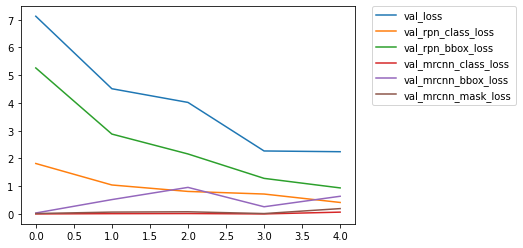

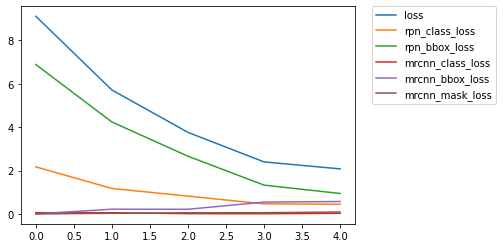

In [86]:
pyplot.plot(val['val_loss'],label='val_loss')
pyplot.plot(val['val_rpn_class_loss'],label='val_rpn_class_loss')
pyplot.plot(val['val_rpn_bbox_loss'],label='val_rpn_bbox_loss')
pyplot.plot(val['val_mrcnn_class_loss'],label='val_mrcnn_class_loss')
pyplot.plot(val['val_mrcnn_bbox_loss'],label='val_mrcnn_bbox_loss')
pyplot.plot(val['val_mrcnn_mask_loss'],label='val_mrcnn_mask_loss')
pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pyplot.show()
pyplot.plot(val['loss'],label='loss')
pyplot.plot(val['rpn_class_loss'],label='rpn_class_loss')
pyplot.plot(val['rpn_bbox_loss'],label='rpn_bbox_loss')
pyplot.plot(val['mrcnn_class_loss'],label='mrcnn_class_loss')
pyplot.plot(val['mrcnn_bbox_loss'],label='mrcnn_bbox_loss')
pyplot.plot(val['mrcnn_mask_loss'],label='mrcnn_mask_loss')
pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [85]:
class SimpleConfig(mrcnn.config.Config):
	NAME = "face_inference"

	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

	NUM_CLASSES = 2

In [93]:
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

model.load_weights(filepath="Face_mask_rcnn.h5", by_name=True)


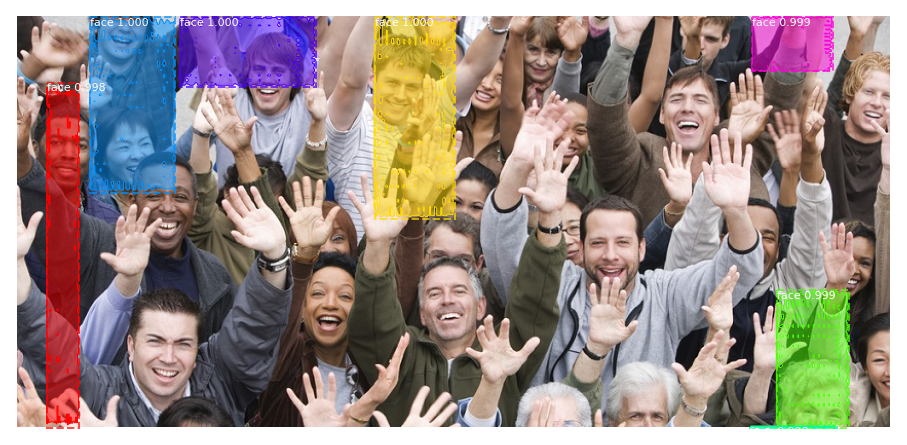

In [94]:
image = cv2.imread("../../asset/images/img.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

r = model.detect([image], verbose=0)

r = r[0]

mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=['BG', 'face'], 
                                  scores=r['scores'])

In [95]:
r['rois']

array([[  0,  71, 171, 154],
       [  0, 348, 197, 426],
       [  0, 158,  68, 291],
       [  0, 716,  53, 795],
       [266, 740, 400, 810],
       [ 64,  29, 400,  60],
       [399, 714, 400, 799]])

In [ ]:
print(tf.__version__)